![Quora-1.png](attachment:Quora-1.png)

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [2]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

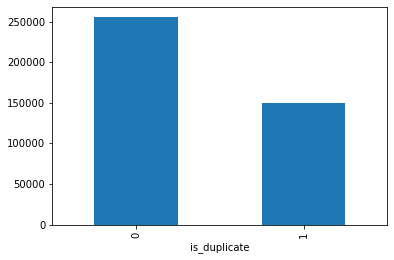

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [7]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [8]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



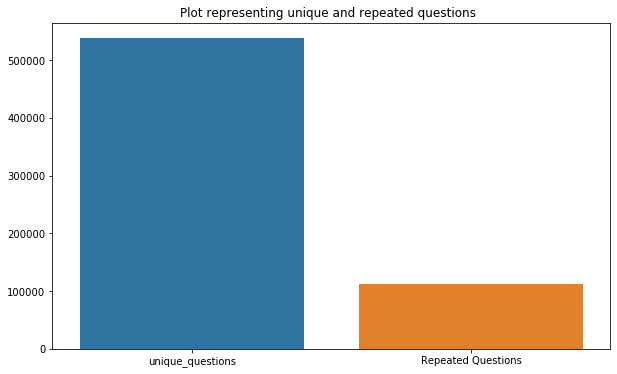

In [9]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [10]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



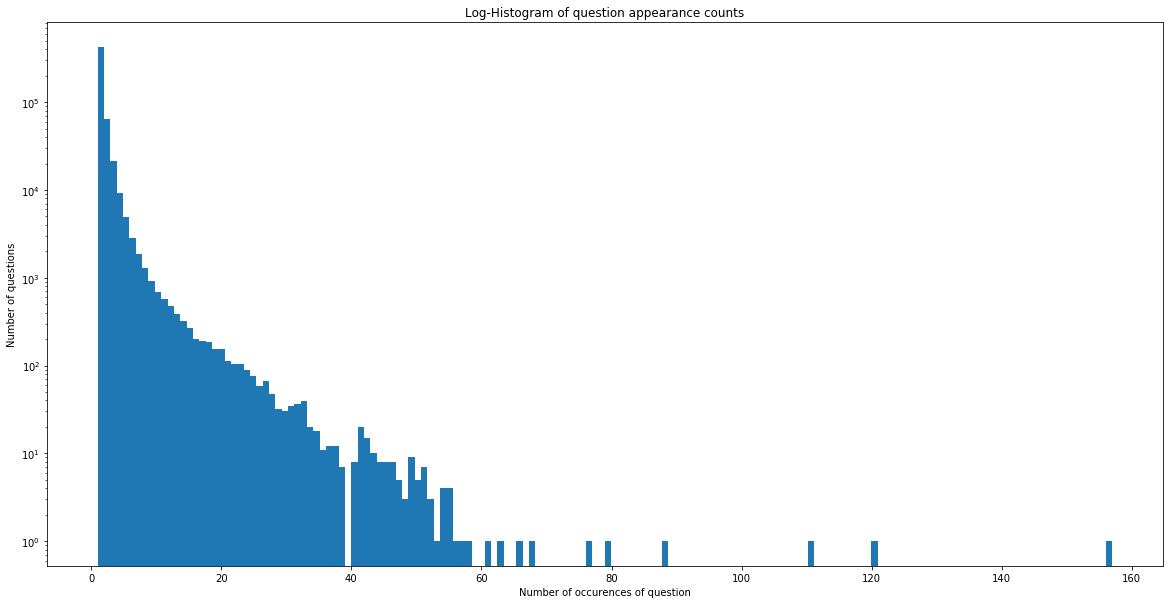

In [11]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [12]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [13]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [14]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [15]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

C:\Users\SUBHODAYA KUMAR\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

C:\Users\SUBHODAYA KUMAR\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



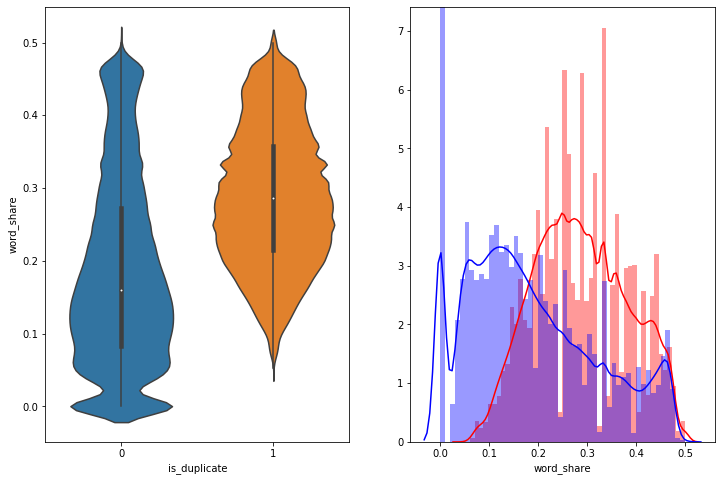

In [16]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

C:\Users\SUBHODAYA KUMAR\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

C:\Users\SUBHODAYA KUMAR\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



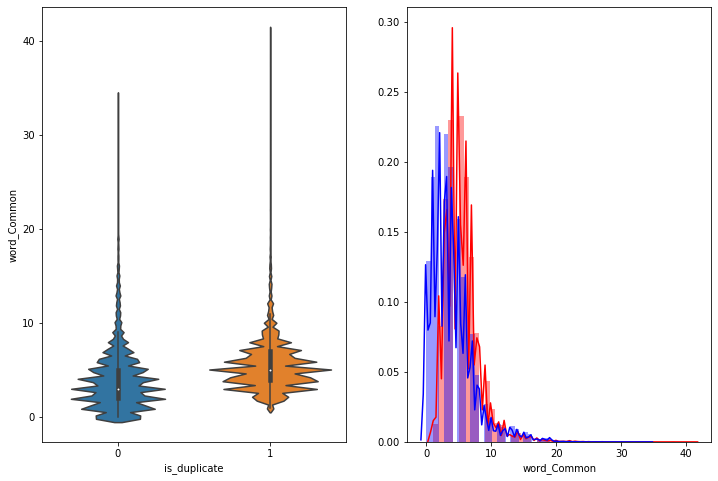

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

In [18]:
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

C:\Users\SUBHODAYA KUMAR\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [19]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [20]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [21]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [22]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='Latin')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False, encoding='Latin')
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [23]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s', encoding='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s', encoding ='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [24]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110303
Total number of words in non duplicate pair questions : 33194892


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


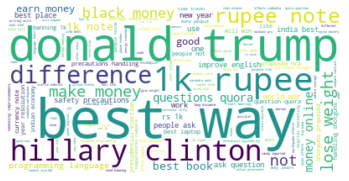

In [25]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


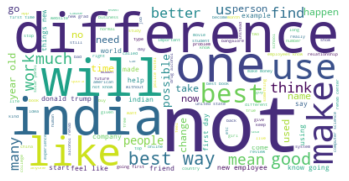

In [26]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

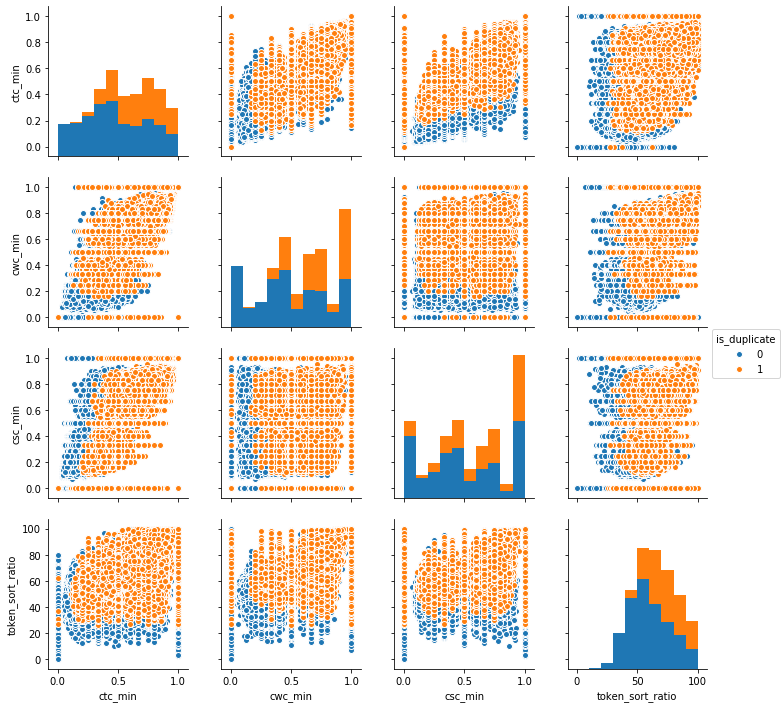

In [27]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

C:\Users\SUBHODAYA KUMAR\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

C:\Users\SUBHODAYA KUMAR\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



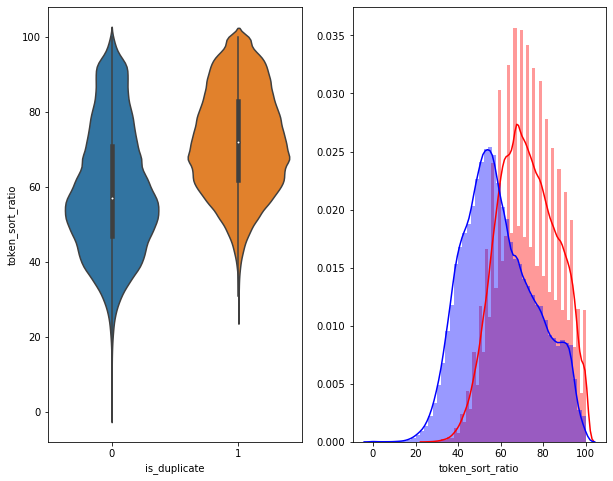

In [28]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

C:\Users\SUBHODAYA KUMAR\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

C:\Users\SUBHODAYA KUMAR\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



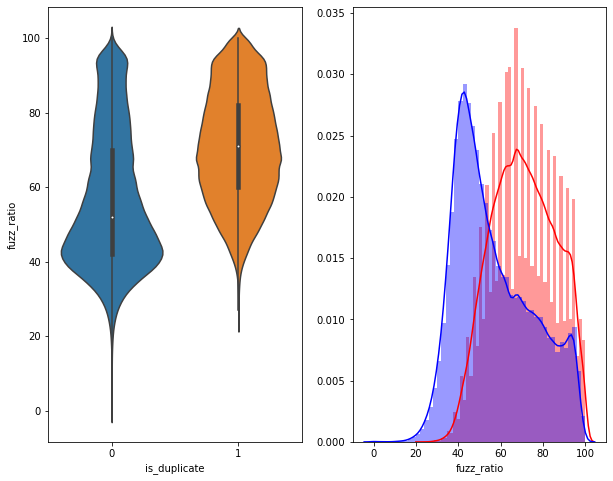

In [29]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [30]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [31]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.077s...
[t-SNE] Computed neighbors for 5000 samples in 0.857s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.547s
[t-SNE] Iteration 50: error = 80.9720154, gradient norm = 0.0451379 (50 iterations in 3.571s)
[t-SNE] Iteration 100: error = 70.4389801, gradient norm = 0.0098959 (50 iterations in 2.666s)
[t-SNE] Iteration 150: error = 68.6479645, gradient norm = 0.0059423 (50 iterations in 2.693s)
[t-SNE] Iteration 200: error = 67.8050308, gradient norm = 0.0040715 (50 iterations in 3.048s)
[t-SNE] Iteration 250: error = 67.3068771, gradient norm = 0.0031636

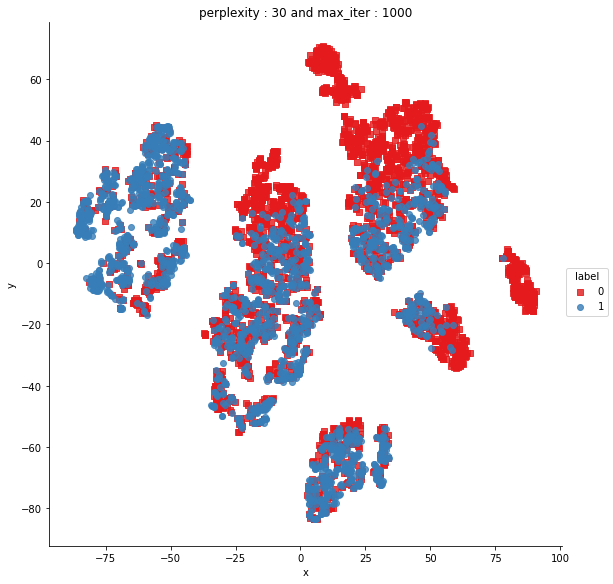

In [32]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [33]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.057s...
[t-SNE] Computed neighbors for 5000 samples in 0.768s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.441s
[t-SNE] Iteration 50: error = 80.3915558, gradient norm = 0.0316218 (50 iterations in 12.741s)
[t-SNE] Iteration 100: error = 69.1371078, gradient norm = 0.0033516 (50 iterations in 7.243s)
[t-SNE] Iteration 150: error = 67.6461716, gradient norm = 0.0017935 (50 iterations in 5.425s)
[t-SNE] Iteration 200: error = 67.0881958, gradient norm = 0.0012118 (50 iterations in 6.252s)
[t-SNE] Iteration 250: error = 66.7614822, gradient norm = 0.000885

In [34]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [35]:
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [36]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [37]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [39]:
import en_core_web_sm
nlp = en_core_web_sm.load()

# en_vectors_web_lg, which includes over 1 million unique vectors.

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:56:04<00:00, 58.05it/s]


In [40]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:56:43<00:00, 57.72it/s]


In [41]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [42]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [43]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [44]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [45]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-19.025082,30.407703,-131.289403,-132.103405,52.904241,90.266851,18.937702,-5.182964,-61.376455,-151.893309,...,-87.327562,102.562203,23.157326,73.647910,-16.079642,-2.087053,142.494740,-140.396991,14.361547,-22.044196
1,-107.513391,76.485826,-138.399411,-128.175290,-29.019105,74.449385,24.753921,16.162435,-4.345508,-35.754816,...,-152.350907,56.232683,112.224383,68.668525,-132.461794,5.614577,63.443425,-125.084109,-74.360633,23.123067
2,-98.370832,-105.838499,-85.035038,-135.944167,63.274705,57.573162,3.784954,40.183860,27.080281,-59.880296,...,-111.718714,125.991654,39.411464,91.816007,-55.469447,38.768498,-7.379207,-123.235320,-2.688627,-5.207624
3,11.846884,-69.441897,-104.972933,-33.480250,26.744677,142.427756,8.649164,38.479152,-24.331226,-46.316330,...,65.919951,24.812937,-71.534837,27.133131,50.103039,-88.737474,31.376285,-66.085595,-84.347586,7.047811
4,-77.952286,2.390032,-191.634536,-225.280350,141.381445,15.397885,-38.772809,102.841476,84.803196,-209.916704,...,-134.909382,173.287179,36.020206,135.444075,-32.498977,150.990705,109.611367,-171.882083,-66.312015,-162.713978


In [46]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-28.113374,14.071277,-110.017215,-121.012773,55.654946,97.055857,36.225506,-8.014744,-46.942517,-135.547529,...,-63.734833,95.815088,13.500244,89.460432,-3.119276,-28.378399,103.745091,-118.916593,-14.315195,-14.894116
1,-31.698307,80.247898,-171.282321,-224.183348,-51.760656,100.503527,-133.589197,-1.417115,-12.462780,-41.630980,...,-148.637855,109.711094,62.538761,72.154373,-137.756543,5.251177,63.611638,-165.109513,-94.521662,25.105437
2,-52.978778,7.761058,-145.027086,-74.633722,5.409296,36.514725,-83.806982,77.081301,27.657251,21.314997,...,-122.836908,130.318538,44.760427,4.675825,-56.794317,-6.889844,32.630608,-11.958574,-34.432986,28.749957
3,-28.516060,22.681441,-119.779502,-58.153846,10.842537,90.849296,-0.593638,-6.998695,20.539878,-5.490560,...,-88.775479,82.716187,-63.615549,-4.947012,-58.495738,-14.816066,100.331752,11.372287,-65.016260,-20.112201
4,-28.920562,-47.628021,-90.717239,-73.382467,69.571516,81.649124,-24.962595,47.079588,-1.234543,-100.526939,...,17.840810,42.080070,-60.014180,19.771544,-13.976706,8.539354,75.278644,-77.371828,24.389920,-26.920906


In [47]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


## storing the data into csv file

In [49]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
   # df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file </h2>

In [50]:
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [88]:
if os.path.isfile('final_features.csv'):
    data = pd.read_csv('final_features.csv',nrows=50000,encoding='utf-8')

In [89]:
data.head()

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,...,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689


In [90]:
data.loc[:, data.isnull().any()].columns

Index(['227_x', '228_x', '229_x', '230_x', '231_x', '232_x', '233_x', '234_x',
       '235_x', '236_x',
       ...
       '374_y', '375_y', '376_y', '377_y', '378_y', '379_y', '380_y', '381_y',
       '382_y', '383_y'],
      dtype='object', length=541)

In [91]:
data.fillna(0,inplace=True)

In [92]:
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

<h2>4.2 convert strings to numeric</h2>

In [93]:
# we convert all the features into numeric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
134_x
135_x
136

In [94]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

<h2> 4.3 Random train test split( 70:30) </h2>

In [95]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [96]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (5574, 794)
Number of data points in test data : (2389, 794)


In [97]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6275565123789021 Class 1:  0.37244348762109797
---------- Distribution of output variable in train data ----------
Class 0:  0.37254081205525325 Class 1:  0.37254081205525325


In [98]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8804145715658872


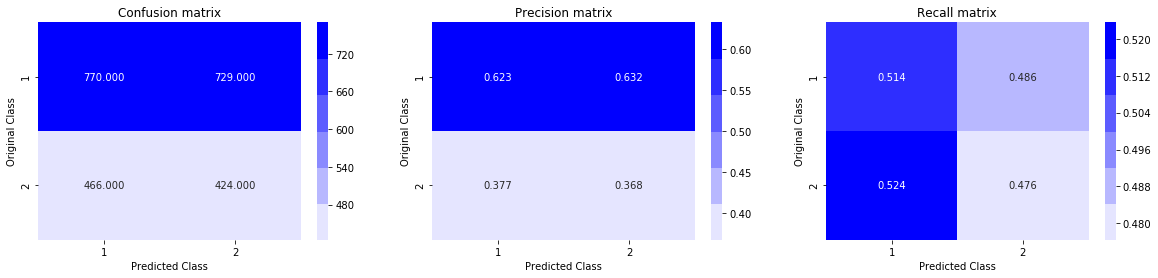

In [99]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6602941458058452
For values of alpha =  0.0001 The log loss is: 0.6602941458058452
For values of alpha =  0.001 The log loss is: 0.5268530631377067
For values of alpha =  0.01 The log loss is: 0.54944181089507
For values of alpha =  0.1 The log loss is: 0.5302542903739512
For values of alpha =  1 The log loss is: 0.5319124562898968
For values of alpha =  10 The log loss is: 0.5447522069186527


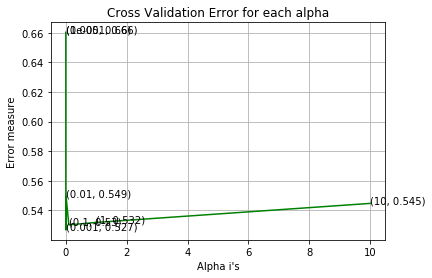

For values of best alpha =  0.001 The train log loss is: 0.47222347407850984
For values of best alpha =  0.001 The test log loss is: 0.5268530631377067
Total number of data points : 2389


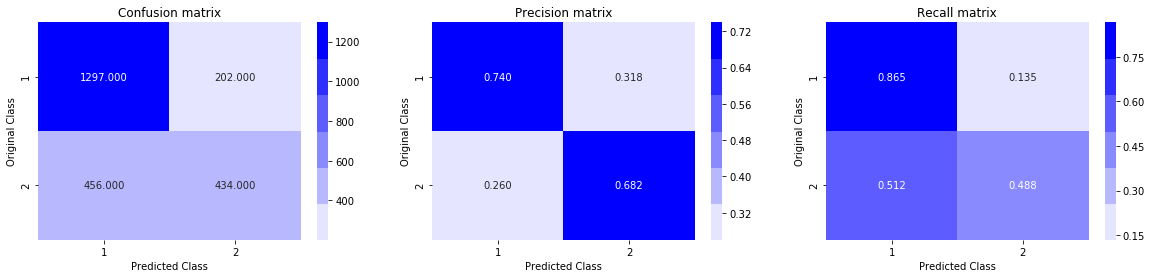

In [100]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6602941458058452
For values of alpha =  0.0001 The log loss is: 0.6602941458058452
For values of alpha =  0.001 The log loss is: 0.6602941458058452
For values of alpha =  0.01 The log loss is: 0.6602941458058452
For values of alpha =  0.1 The log loss is: 0.6602941458058452
For values of alpha =  1 The log loss is: 0.6602941458058452
For values of alpha =  10 The log loss is: 0.6602941458058452


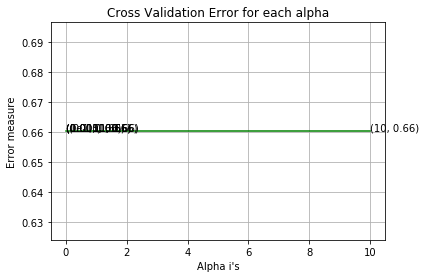

For values of best alpha =  1e-05 The train log loss is: 0.6602434620503466
For values of best alpha =  1e-05 The test log loss is: 0.6602941458058452
Total number of data points : 2389


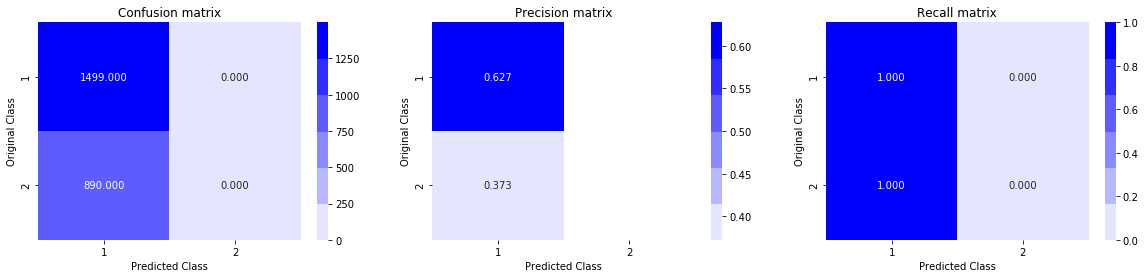

In [101]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [102]:
%%time
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.68489	valid-logloss:0.68505
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61430	valid-logloss:0.61541
[20]	train-logloss:0.56308	valid-logloss:0.56568
[30]	train-logloss:0.52390	valid-logloss:0.52842
[40]	train-logloss:0.49276	valid-logloss:0.49978
[50]	train-logloss:0.46825	valid-logloss:0.47697
[60]	train-logloss:0.44876	valid-logloss:0.45967
[70]	train-logloss:0.43260	valid-logloss:0.44560
[80]	train-logloss:0.41931	valid-logloss:0.43463
[90]	train-logloss:0.40801	valid-logloss:0.42600
[100]	train-logloss:0.39834	valid-logloss:0.41820
[110]	train-logloss:0.39039	valid-logloss:0.41194
[120]	train-logloss:0.38300	valid-logloss:0.40690
[130]	train-logloss:0.37660	valid-logloss:0.40269
[140]	train-logloss:0.37093	valid-logloss:0.39969
[150]	train-logloss:0.36551	valid-logloss:0.39695
[160]	train-logloss:0.36025	valid-logloss:0.39456
[170]	trai

Total number of data points : 2389


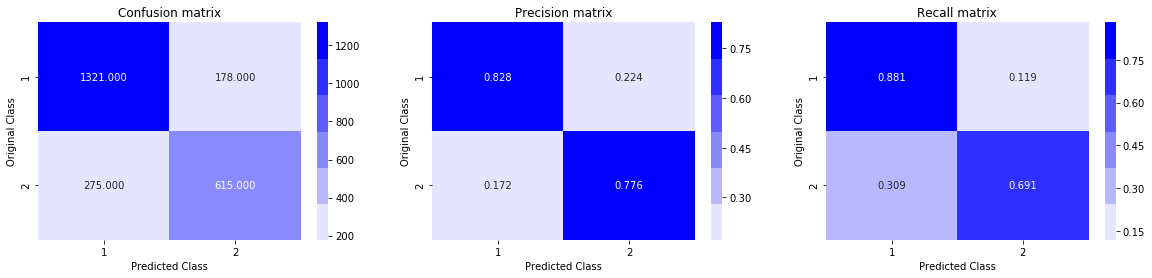

In [103]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [25]:
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

# TF-IDF vectorization

In [143]:
df1 = pd.read_csv("nlp_features_train.csv",nrows=50000,encoding='latin-1')
df2 = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
df3 = df2.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df4 = df1.merge(df2, on='id',how='left')

In [144]:
df4.columns

Index(['id', 'qid1_x', 'qid2_x', 'question1_x', 'question2_x',
       'is_duplicate_x', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'qid1_y', 'qid2_y',
       'question1_y', 'question2_y', 'is_duplicate_y', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

In [145]:
df4.isnull().any()

id                      False
qid1_x                  False
qid2_x                  False
question1_x              True
question2_x              True
is_duplicate_x          False
cwc_min                 False
cwc_max                 False
csc_min                 False
csc_max                 False
ctc_min                 False
ctc_max                 False
last_word_eq            False
first_word_eq           False
abs_len_diff            False
mean_len                False
token_set_ratio         False
token_sort_ratio        False
fuzz_ratio              False
fuzz_partial_ratio      False
longest_substr_ratio    False
qid1_y                  False
qid2_y                  False
question1_y             False
question2_y             False
is_duplicate_y          False
freq_qid1               False
freq_qid2               False
q1len                   False
q2len                   False
q1_n_words              False
q2_n_words              False
word_Common             False
word_Total

In [146]:
df4 = df4.fillna(' ')
df4.isnull().any()

id                      False
qid1_x                  False
qid2_x                  False
question1_x             False
question2_x             False
is_duplicate_x          False
cwc_min                 False
cwc_max                 False
csc_min                 False
csc_max                 False
ctc_min                 False
ctc_max                 False
last_word_eq            False
first_word_eq           False
abs_len_diff            False
mean_len                False
token_set_ratio         False
token_sort_ratio        False
fuzz_ratio              False
fuzz_partial_ratio      False
longest_substr_ratio    False
qid1_y                  False
qid2_y                  False
question1_y             False
question2_y             False
is_duplicate_y          False
freq_qid1               False
freq_qid2               False
q1len                   False
q2len                   False
q1_n_words              False
q2_n_words              False
word_Common             False
word_Total

In [147]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df4,df4['is_duplicate_x'],stratify=df4['is_duplicate_x'], random_state=32)

In [148]:
X_train= X_train.drop(['is_duplicate_x'],axis=1)
X_test = X_test.drop(['is_duplicate_x'], axis=1)
print(X_train.shape)
print(X_test.shape)

(37500, 36)
(12500, 36)


In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10)

# merge texts
questions = list(X_train['question1_x']) + list(X_train['question2_x'])
#questions = list(df['question1']) + list(df['question2'])


vectorizer.fit(questions)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [150]:
train_ques1= vectorizer.transform(X_train['question1_x'])
print("Shape of matrix after one hot encodig ",tfidf_train_ques1.shape)

print("the number of unique words ", train_ques1.get_shape()[1])

Shape of matrix after one hot encodig  (37500, 13365)
the number of unique words  13365


In [151]:
train_ques2= vectorizer.transform(X_train['question2_x'])
print("Shape of matrix after one hot encodig ",train_ques2.shape)
print("the number of unique words ", train_ques2.get_shape()[1])

Shape of matrix after one hot encodig  (37500, 13365)
the number of unique words  13365


In [152]:
# extraction  features from train  data frame 
X_train_df = X_train.drop(['id','qid1_y','qid2_y','question1_x','question2_x', 'question1_y','question2_y','qid1_x','qid2_x'], axis=1, inplace=False)

In [153]:
import scipy
# X_train.head()
print("train Shape Before -> ",X_train_df.shape," Type",type(X_train_df))

#so we need to convert our feature data into sparse matrix so that we will combine our feature and and tfidf vec 
train_sp = scipy.sparse.csr_matrix(X_train_df)

print("train Shape After-> ",train_sp.shape," Type",type(train_sp))

train Shape Before ->  (37500, 27)  Type <class 'pandas.core.frame.DataFrame'>
train Shape After->  (37500, 27)  Type <class 'scipy.sparse.csr.csr_matrix'>


In [154]:
test_ques1= vectorizer.transform(X_test['question1_x'])
print("Shape of matrix after one hot encodig ",test_ques1.shape)
print("the number of unique words ", test_ques1.get_shape()[1])


test_ques2= vectorizer.transform(X_test['question2_x'])
print("Shape of matrix after one hot encodig ",test_ques2.shape)
print("the number of unique words ", test_ques2.get_shape()[1])

Shape of matrix after one hot encodig  (12500, 13365)
the number of unique words  13365
Shape of matrix after one hot encodig  (12500, 13365)
the number of unique words  13365


In [155]:
# extraction  features from test  data frame 
X_test_df = X_test.drop(['id','qid1_x','qid2_x','question1_x','question2_x','question1_y','question2_y','qid1_y','qid2_y'], axis=1, inplace=False)


print("test Shape Before -> ",X_test_df.shape," Type",type(X_test_df))

#so we need to convert our feature data into sparse matrix so that we will combine our feature and and tfidf vec 
test_sp = scipy.sparse.csr_matrix(X_test_df)

print("test Shape After-> ",test_sp.shape," Type",type(test_sp))

test Shape Before ->  (12500, 27)  Type <class 'pandas.core.frame.DataFrame'>
test Shape After->  (12500, 27)  Type <class 'scipy.sparse.csr.csr_matrix'>


In [156]:
# combining our tfidf and features into one 

# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack


tfidf_train = hstack((train_ques1,train_ques2))

# test features(feat + tfidfvec)
tfidf_test = hstack((test_ques1,test_ques2))

#final train and test data shape 
print("train data shape",tfidf_train.shape)

print("Test data shape ",tfidf_test.shape)

train data shape (37500, 26730)
Test data shape  (12500, 26730)


In [157]:
from scipy.sparse import hstack

tfidf_train = hstack((train_sp,train_ques1,train_ques2))

# test features(feat + tfidfvec)
tfidf_test = hstack((test_sp,test_ques1,test_ques2))

#final train and test data shape 
print("train data shape",tfidf_train.shape)

print("Test data shape ",tfidf_test.shape)

train data shape (37500, 26757)
Test data shape  (12500, 26757)


In [158]:
print("Final Shape of the Data matrix")
print(tfidf_train.shape, y_train.shape)

print(tfidf_test.shape, y_test.shape)

Final Shape of the Data matrix
(37500, 26757) (37500,)
(12500, 26757) (12500,)


# Confusion Matrix

In [159]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.0023751498693394147
For values of alpha =  0.0001 The log loss is: 0.0050051175095237625
For values of alpha =  0.001 The log loss is: 0.0006058219726828397
For values of alpha =  0.01 The log loss is: 0.010728604411489364
For values of alpha =  0.1 The log loss is: 0.2356403944840915
For values of alpha =  1 The log loss is: 0.4485812357704052
For values of alpha =  10 The log loss is: 0.5386980081174446


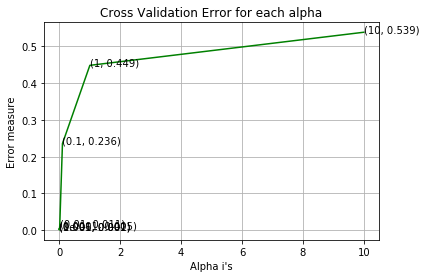

For values of best alpha =  0.001 The train log loss is: 0.000517379777437629
For values of best alpha =  0.001 The test log loss is: 0.0006058219726828397
Total number of data points : 12500


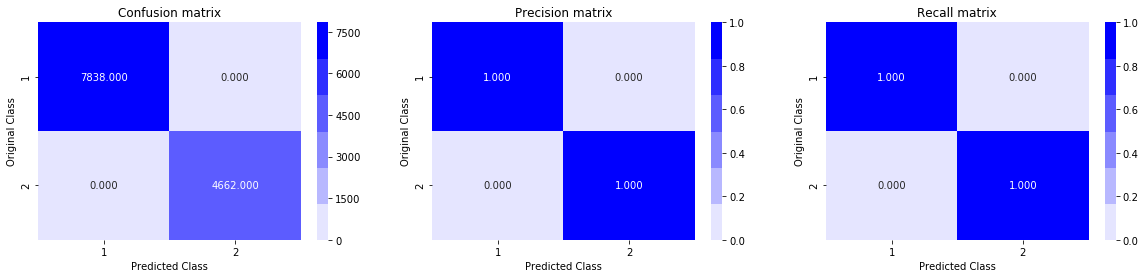

In [160]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=�hinge�, penalty=�l2�, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=�optimal�, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, �])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(tfidf_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_train, y_train)
    predict_y = sig_clf.predict_proba(tfidf_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(tfidf_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_train, y_train)

predict_y = sig_clf.predict_proba(tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Linear SVM

For values of alpha =  1e-05 The log loss is: 0.6605122771651409
For values of alpha =  0.0001 The log loss is: 0.10204513144088276
For values of alpha =  0.001 The log loss is: 0.22374637145162124
For values of alpha =  0.01 The log loss is: 0.2879976443485771
For values of alpha =  0.1 The log loss is: 0.0003417792363332606
For values of alpha =  1 The log loss is: 0.5772101790536585
For values of alpha =  10 The log loss is: 0.6605122708573192


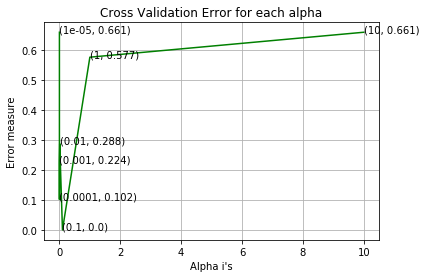

For values of best alpha =  0.1 The train log loss is: 0.00037676084598850187
For values of best alpha =  0.1 The test log loss is: 0.0003417792363332606
Total number of data points : 12500


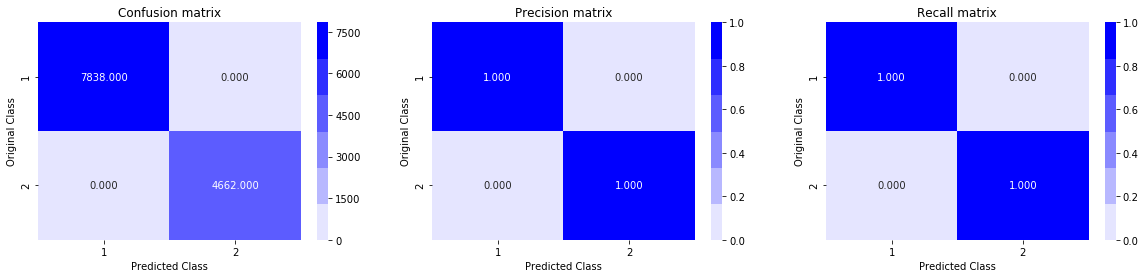

In [161]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(tfidf_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_train, y_train)
    predict_y = sig_clf.predict_proba(tfidf_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(tfidf_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_train, y_train)

predict_y = sig_clf.predict_proba(tfidf_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# XGBOOST

In [173]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as sc
from xgboost import XGBClassifier

params = {
        
        "learning_rate":sc.uniform(0.05,0.3),
        'max_depth': sc.randint(3,15),
        "min_child_weight" : [ 1, 3, 5, 7 ],
        'gamma': sc.uniform(0.0,0.5)
        }
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',n_jobs=-1)

xgb_random = RandomizedSearchCV(xgb_model, param_distributions = params,n_iter=10,
                         scoring = 'neg_log_loss', n_jobs = -1,cv=3)
xgb_random.fit(tfidf_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monot...
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023187D96940>,
                                        'learning_rate'

In [174]:
xgb_random.best_params_

{'gamma': 0.04133373083005837,
 'learning_rate': 0.2008922055113928,
 'max_depth': 13,
 'min_child_weight': 1}

The train log loss is:  0.00026656281055114506
The test log loss is :  0.00026655894898391783


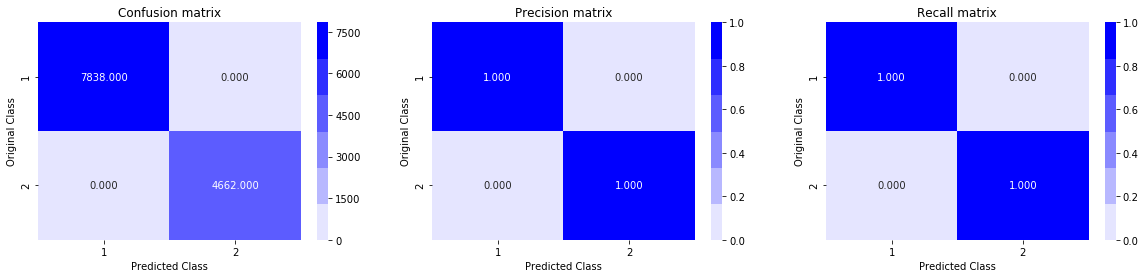

In [179]:
bst = xgb.XGBClassifier(max_depth=13,learning_rate=0.2,objective='binary:logistic',gamma=0.04,min_child_weight=1,n_jobs=-1)
bst.fit(tfidf_train, y_train)   


clf_calib = CalibratedClassifierCV(bst, method="sigmoid")
clf_calib.fit(tfidf_train, y_train)

predict_y = clf_calib.predict_proba(tfidf_train)

print("The train log loss is: ",log_loss(y_train, predict_y,labels=bst.classes_, eps=1e-15))

predict_y = clf_calib.predict_proba(tfidf_test)
print("The test log loss is : ",log_loss(y_test, predict_y,labels=bst.classes_, eps=1e-15))


predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

# TF-IDF-W2V Vectorization

In [180]:
# Load Basic Features
df5 = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
#Taking samples of 50k
# Creating duplicate of df_50k for TFIDF Weighted Word2Vec
df5 = df5.sample(n = 50000)
print("Columns in dftw_50k dataframe:\n")
print(df5.columns)

df5.head()

Columns in dftw_50k dataframe:

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
156115,156115,117180,70505,Who will win the election TRUMP or CLINTON?,Who will win the US election in 2016?,1,16,10,43,37,8,8,5.0,16.0,0.312500,26,6
209819,209819,314201,314202,What are the best ways to install antivirus in...,How can I install an antivirus software in my ...,0,1,1,69,53,13,10,5.0,23.0,0.217391,2,0
391384,391384,11910,21938,"How safe is Papua New Guinea, and how does it'...","How safe is Papua New Guinea, and how does it'...",0,1,5,80,82,15,15,13.0,28.0,0.464286,6,4
84036,84036,30851,142135,Does Kurkure contain plastic?,Should kurkure be banned in India?,0,3,1,29,34,4,6,1.0,10.0,0.100000,4,2
23412,23412,43852,43853,What should I do when I think everything goes ...,What do I do when nothing goes right in life?,1,4,2,63,45,13,10,7.0,21.0,0.333333,6,2


In [181]:
df5['question1'] = df5['question1'].apply(lambda x: str(x))
df5['question2'] = df5['question2'].apply(lambda x: str(x))

In [182]:
x_tr = df5.drop(['is_duplicate', 'id'], axis = 1)
y_tr = df5['is_duplicate']

In [185]:
#Train Test Split
from sklearn.model_selection import train_test_split

x_train1, x_test1, y_train1, y_test1 = train_test_split(x_tr, y_tr, test_size = 0.3, random_state = 0, shuffle = False)

In [186]:
print("Shape of x train data:", x_train1.shape)
print("Shape of x test data:", x_test1.shape)
print("Shape of y train data:", y_train1.shape)
print("Shape of y test data:", y_test1.shape)

Shape of x train data: (35000, 15)
Shape of x test data: (15000, 15)
Shape of y train data: (35000,)
Shape of y test data: (15000,)


In [187]:

# Importing library
from sklearn.feature_extraction.text import TfidfVectorizer

# Merge texts
questions = list(x_train1['question1']) + list(x_train1['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))


In [189]:
# Defining a function 'vec' to create TF-IDF Weighted Word2Vec

# Importing libraries
import os
import spacy
from tqdm import tqdm

def vec(x_tr):

    # en_vectors_web_lg, which includes over 1 million unique vectors.
    nlp = spacy.load('en_core_web_sm')

    vecs = []
    
    # https://github.com/noamraph/tqdm
    # tqdm is used to print the progress bar
    for qu in tqdm(list(x_tr)):
        
        doc = nlp(qu) 
        # 96 is the number of dimensions of vectors 
        mean_vec = np.zeros([len(doc), 96])
        
        for word in doc:
            # word2vec
            vec = word.vector
            # fetch df score
            
            try:
                idf = word2tfidf[str(word)]
                
            except:
                idf = 0
                
            # compute final vec
            mean_vec += vec * idf
            
        mean_vec = mean_vec.mean(axis = 0)
        vecs.append(mean_vec)
    return vecs

In [190]:
# Calling 'vec' function for train question1

x_train1['que1_tw'] = vec(x_train1['question1'])

100%|████████████████████████████████████████████████████████████████████████████| 35000/35000 [09:59<00:00, 58.42it/s]


In [195]:
# Calling 'vec' function for train question1

x_train1['que2_tw'] = vec(x_train1['question2'])

100%|████████████████████████████████████████████████████████████████████████████| 35000/35000 [09:02<00:00, 64.50it/s]


In [192]:
# Calling 'vec' function for test question1

x_test1['que1_tw'] = vec(x_test1['question1'])

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [03:54<00:00, 63.91it/s]


In [193]:
# Calling 'vec' function for test question2

x_test1['que2_tw'] = vec(x_test1['question2'])

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [03:22<00:00, 74.13it/s]


In [196]:
print("Type of x_train1['que1_tw']:", type(x_train1['que1_tw']))
print("Type of x_train1['que2_tw']:", type(x_train1['que2_tw']), '\n')
print("Type of x_test1['que1_tw']:", type(x_test1['que1_tw']))
print("Type of x_test1['que2_tw']:", type(x_test1['que2_tw']), '\n')

print("Shape of x train question1:", x_train1['que1_tw'].shape)
print("Shape of x test question1 data:", x_test1['que1_tw'].shape, '\n')


print("Shape of x train question2:", x_train1['que2_tw'].shape)
print("Shape of x test question2 data:", x_test1['que1_tw'].shape, '\n')

Type of x_train1['que1_tw']: <class 'pandas.core.series.Series'>
Type of x_train1['que2_tw']: <class 'pandas.core.series.Series'> 

Type of x_test1['que1_tw']: <class 'pandas.core.series.Series'>
Type of x_test1['que2_tw']: <class 'pandas.core.series.Series'> 

Shape of x train question1: (35000,)
Shape of x test question1 data: (15000,) 

Shape of x train question2: (35000,)
Shape of x test question2 data: (15000,) 



In [199]:
# Train dataframe

x_tr1 = pd.DataFrame(x_train1['que1_tw'].values.tolist(), index = x_train1.index)

x_tr2 = pd.DataFrame(x_train1['que2_tw'].values.tolist(), index = x_train1.index,
                         columns = np.arange(x_tr1.shape[1], x_tr1.shape[1] * 2))


# Test dataframe

x_te1 = pd.DataFrame(x_test1['que1_tw'].values.tolist(), index = x_test1.index)

x_te2 = pd.DataFrame(x_test1['que2_tw'].values.tolist(), index = x_test1.index,
                         columns = np.arange(x_te1.shape[1], x_te1.shape[1] * 2))

In [200]:
#Concatinating train question1 and train question2 vectors with dataframe

final_tr = pd.concat([x_train1, x_tr1, x_tr2], axis = 1)

# Dropping question1 and question2 columns from final_test dataframe

final_te = pd.concat([x_test1, x_te1, x_te2], axis = 1)

In [202]:
# Filling train dataframe
final_tr = final_tr.fillna(' ')

# Filling test dataframe
final_te = final_te.fillna(' ')

In [203]:
# Dropping question1 and question2 columns from final_train dataframe

final_tr = final_tr.drop(['question1', 'question2', 'que1_tw', 'que2_tw'], axis = 1)

# Dropping question1 and question2 columns from final_test dataframe

final_te = final_te.drop(['question1', 'question2', 'que1_tw', 'que2_tw'], axis = 1)

In [205]:
print("Shape of final_tr dataframe:", final_tr.shape, '\n')

print("Shape of final_te dataframe:", final_te.shape, '\n')

Shape of final_tr dataframe: (35000, 205) 

Shape of final_te dataframe: (15000, 205) 



In [206]:
# Saving final train data
final_tr.to_csv("quora_final_tr.csv")

# Saving final test data
final_te.to_csv("quora_final_te.csv")

In [209]:
# Import libraries
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from datetime import datetime as dt
start = dt.now()

# Parameters we need to try are
param_grid = {'n_estimators' : [5, 10, 20, 40], 'max_depth' : [2, 5, 8, 10]}

rs = RandomizedSearchCV(estimator = XGBClassifier(objective = 'binary:logistic', eval_metric = 'logloss', eta = 0.02),
                          param_distributions = param_grid)

# fit train sets
rs.fit(final_tr, y_train1)

# Prediction
predict1 = rs.predict(final_te)

print("Time taken to run this cell:", dt.now() - start)

Time taken to run this cell: 0:13:59.516168


In [210]:
rs.best_params_

{'n_estimators': 40, 'max_depth': 8}

In [211]:
rs.best_score_

0.7953714285714286

Total number of data points : 15000


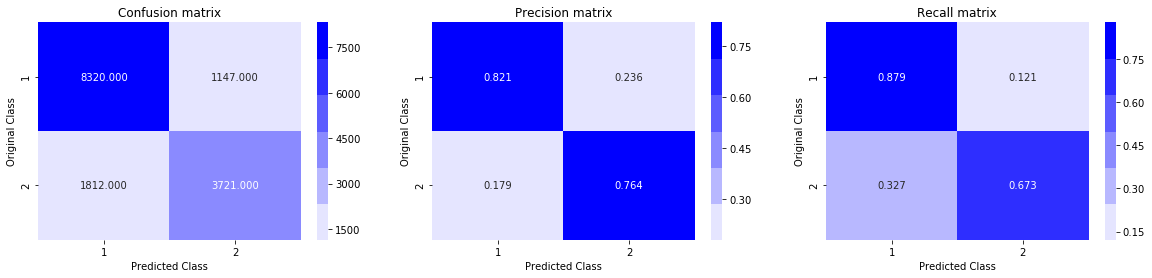

In [213]:
predicted_y = np.array(predict1 > 0.5, dtype = int)

print("Total number of data points :", len(predicted_y))

plot_confusion_matrix(y_test1, predicted_y)

In [215]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 10
params['n_estimators'] = 100

d_train = xgb.DMatrix(final_tr, label= y_train1)
d_test = xgb.DMatrix(final_te, label = y_test1)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20)

xgdmat = xgb.DMatrix(final_tr,y_train1)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test1, predict_y, eps=1e-15))

[00:27:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.68246	valid-logloss:0.68380
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[1]	train-logloss:0.67220	valid-logloss:0.67486
[2]	train-logloss:0.66227	valid-logloss:0.66622
[3]	train-logloss:0.65272	valid-logloss:0.65798
[4]	train-logloss:0.64346	valid-logloss:0.65004
[5]	train-logloss:0.63456	valid-logloss:0.64239
[6]	train-logloss:0.62592	valid-logloss:0.63501
[7]	train-logloss:0.61757	valid-logloss:0.62789
[8]	train-logloss:0.60951	valid-logloss:0.62104
[9]	train-logloss:0.60157	v

[156]	train-logloss:0.26348	valid-logloss:0.38499
[157]	train-logloss:0.26282	valid-logloss:0.38478
[158]	train-logloss:0.26223	valid-logloss:0.38466
[159]	train-logloss:0.26158	valid-logloss:0.38447
[160]	train-logloss:0.26093	valid-logloss:0.38432
[161]	train-logloss:0.26054	valid-logloss:0.38417
[162]	train-logloss:0.26013	valid-logloss:0.38400
[163]	train-logloss:0.25947	valid-logloss:0.38381
[164]	train-logloss:0.25886	valid-logloss:0.38359
[165]	train-logloss:0.25822	valid-logloss:0.38344
[166]	train-logloss:0.25766	valid-logloss:0.38322
[167]	train-logloss:0.25707	valid-logloss:0.38312
[168]	train-logloss:0.25635	valid-logloss:0.38299
[169]	train-logloss:0.25589	valid-logloss:0.38286
[170]	train-logloss:0.25517	valid-logloss:0.38271
[171]	train-logloss:0.25473	valid-logloss:0.38260
[172]	train-logloss:0.25391	valid-logloss:0.38236
[173]	train-logloss:0.25307	valid-logloss:0.38221
[174]	train-logloss:0.25263	valid-logloss:0.38210
[175]	train-logloss:0.25180	valid-logloss:0.38196


[320]	train-logloss:0.19040	valid-logloss:0.37411
[321]	train-logloss:0.19006	valid-logloss:0.37411
[322]	train-logloss:0.18974	valid-logloss:0.37410
[323]	train-logloss:0.18949	valid-logloss:0.37408
[324]	train-logloss:0.18894	valid-logloss:0.37399
[325]	train-logloss:0.18864	valid-logloss:0.37401
[326]	train-logloss:0.18821	valid-logloss:0.37400
[327]	train-logloss:0.18806	valid-logloss:0.37399
[328]	train-logloss:0.18721	valid-logloss:0.37391
[329]	train-logloss:0.18706	valid-logloss:0.37391
[330]	train-logloss:0.18677	valid-logloss:0.37393
[331]	train-logloss:0.18653	valid-logloss:0.37389
[332]	train-logloss:0.18626	valid-logloss:0.37391
[333]	train-logloss:0.18575	valid-logloss:0.37388
[334]	train-logloss:0.18525	valid-logloss:0.37381
[335]	train-logloss:0.18485	valid-logloss:0.37378
[336]	train-logloss:0.18426	valid-logloss:0.37374
[337]	train-logloss:0.18394	valid-logloss:0.37377
[338]	train-logloss:0.18371	valid-logloss:0.37376
[339]	train-logloss:0.18314	valid-logloss:0.37370


In [ ]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Model Comparision "
ptable.field_names = [ 'Model Name', 'Tokenizer', 'Test Log Loss']
ptable.add_row(["Random","TFIDF Weighted W2V","0.88"])
ptable.add_row(["Logistic Regression","TFIDF Weighted W2V","0.52"])
ptable.add_row(["Linear SVM","TFIDF Weighted W2V","0.66"])
ptable.add_row(["XGBoost","TFIDF Weighted W2V","0.373"])
ptable.add_row(["\n","\n","\n","\n"])
ptable.add_row(["Logistic Regression","TFIDF","0.42"])
ptable.add_row(["Linear SVM","TFIDF","0.439"])
ptable.add_row(["XGBoost","TFIDF","0.386"])
print(ptable)